<a href="https://colab.research.google.com/github/RayChen0623/Practice-/blob/master/Moloco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import gspread
import datetime as dt
import os
import gspread_dataframe as gd
from oauth2client.client import GoogleCredentials
from google.colab import drive
from google.colab import auth

auth.authenticate_user()

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
ls "/content/drive/My Drive/Moloco/Adops & Data Scientist Sample Data - Q1 Analytics.csv"

'/content/drive/My Drive/Moloco/Adops & Data Scientist Sample Data - Q1 Analytics.csv'


## Q1

In [0]:
df_Q1 = pd.read_csv('/content/drive/My Drive/Moloco/Adops & Data Scientist Sample Data - Q1 Analytics.csv', encoding='latin-1')

In [5]:
df_Q1.head()

,ts,user_id,country_id,site_id
0,2019-02-01 00:01:24,LC36FC,TL6,N0OTG
1,2019-02-01 00:10:19,LC39B6,TL6,N0OTG
2,2019-02-01 00:21:50,LC3500,TL6,N0OTG
3,2019-02-01 00:22:50,LC374F,TL6,N0OTG
4,2019-02-01 00:23:44,LCC1C3,TL6,QGO3G


In [6]:
df_Q1.shape

(3553, 4)

#### Consider only the rows with country_id = "BDV" (there are 844 such rows). For each site_id, we can compute the number of unique user_id's found in these 844 rows. Which site_id has the largest number of unique users? And what's the number?

In [7]:
df_Q1[df_Q1['country_id'] == 'BDV'][['site_id', 'user_id']].drop_duplicates(
  ).groupby('site_id').count().sort_values(by = 'user_id', ascending = False).reset_index()

,site_id,user_id
0,5NPAU,544
1,N0OTG,90
2,3POLC,2


#### Between 2019-02-03 00:00:00 and 2019-02-04 23:59:59, there are four users who visited a certain site more than 10 times. Find these four users & which sites they (each) visited more than 10 times. (Simply provides four triples in the form (user_id, site_id, number of visits) in the box below.)

In [0]:
df_Q1['ts'] = pd.to_datetime(df_Q1['ts'])

In [9]:
df_Q1[(df_Q1['ts'] >= '2019-02-03') & (df_Q1['ts'] < '2019-02-05')][['user_id', 'site_id', 'ts']].groupby(
    ['user_id', 'site_id']).count().sort_values(by = 'ts', ascending = False).reset_index().head(4)

,user_id,site_id,ts
0,LC3A59,N0OTG,26
1,LC06C3,N0OTG,25
2,LC3C9D,N0OTG,17
3,LC3C7E,3POLC,15


#### For each site, compute the unique number of users whose last visit (found in the original data set) was to that site. For instance, user "LC3561"'s last visit is to "N0OTG" based on timestamp data. Based on this measure, what are top three sites? (hint: site "3POLC" is ranked at 5th with 28 users whose last visit in the data set was to 3POLC; simply provide three pairs in the form (site_id, number of users).)

In [10]:
df_Q1.merge(df_Q1[['user_id', 'ts']].groupby(['user_id']).max().reset_index(), on = ['user_id', 'ts']
            )[['site_id', 'user_id']].groupby('site_id').count().sort_values(
                by = 'user_id', ascending = False).reset_index().head(3)

,site_id,user_id
0,5NPAU,992
1,N0OTG,561
2,QGO3G,289


#### For each user, determine the first site he/she visited and the last site he/she visited based on the timestamp data. Compute the number of users whose first/last visits are to the same website. What is the number?


In [11]:
(len(df_Q1.merge(df_Q1[['user_id', 'ts']].groupby(['user_id']).min().reset_index(), on = ['user_id', 'ts']).merge(
    df_Q1.merge(df_Q1[['user_id', 'ts']].groupby(['user_id']).max().reset_index(), on = ['user_id', 'ts']), 
    on = ['user_id', 'site_id']))) - (len(df_Q1.merge(df_Q1[['user_id', 'ts']].groupby(['user_id']).min().reset_index(), on = ['user_id', 'ts']).merge(
    df_Q1.merge(df_Q1[['user_id', 'ts']].groupby(['user_id']).max().reset_index(), on = ['user_id', 'ts']), 
    on = ['user_id', 'site_id', 'ts'])))

409

#### First Visit = Last Visit

In [12]:
len(df_Q1.merge(df_Q1[['user_id', 'ts']].groupby(['user_id']).min().reset_index(), on = ['user_id', 'ts']).merge(
    df_Q1.merge(df_Q1[['user_id', 'ts']].groupby(['user_id']).max().reset_index(), on = ['user_id', 'ts']), 
    on = ['user_id', 'site_id', 'ts']))

1261

## Q2

#### The data contains 300 rows and 3 columns (from the left, A, B, and C). Please build a good regression model which explains column C by a function of  A and B. 

Note: Please do not use any ML libraries or packages. You can simply attach plot of data points and your regression model that fits the data points and of course, code point (preferably Github).

In [0]:
df_Q2 = pd.read_csv('/content/drive/My Drive/Moloco/Adops & Data Scientist Sample Data - Q2 Regression.csv', 
                    header = None ,encoding='latin-1')

In [0]:
df_Q2.columns = ['A', 'B', 'C']

In [15]:
pp.ProfileReport(df_Q2)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,3
Number of observations,300
Total Missing (%),0.0%
Total size in memory,7.2 KiB
Average record size in memory,24.4 B
Numeric,3
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


### Apply R to build regression 

In [16]:
df_Q2[df_Q2['C'] == -10000] ##outlier

,A,B,C
200,10.1,-2.24,-10000.0


In [0]:
df_Q2.loc[200]['C'] = df_Q2['C'].mean() #replace outlier with mean

In [18]:
ls "/content/drive/My Drive/Moloco/"

'Adops & Data Scientist Sample Data - Q1 Analytics.csv'    df_Q2.csv
'Adops & Data Scientist Sample Data - Q2 Regression.csv'   Moloco.ipynb


In [0]:
df_Q2.to_csv('df_Q2.csv')
!cp df_Q2.csv "/content/drive/My Drive/Moloco/"

In [0]:
%load_ext rpy2.ipython

In [21]:
%%R 

install.packages("data.table")
install.packages("ggplot2")
library(data.table)
library(ggplot2)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/data.table_1.12.6.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 4944372 bytes (4.7 MB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python

In [0]:
%%R 

df_Q2_R = read.table("df_Q2.csv", header = TRUE, sep = ",")
df_Q2_R = df_Q2_R[, c(-1)]

In [23]:
%%R 

a = cbind(df_Q2_R$A, df_Q2_R$B, df_Q2_R$C)
dim(a)

[1] 300   3


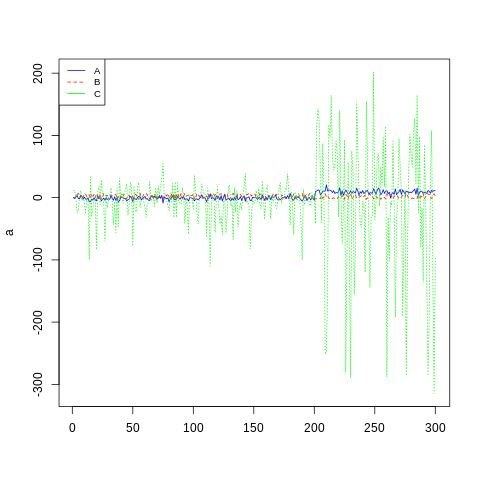

In [24]:
%%R

matplot(a,type="l",col=c("blue","red", "green"))
legend('topleft',c("A","B", "C"),lty=1:2, col = c("blue","red", "green"),cex=0.8)

In [0]:
%%R 

model = lm(C ~ A * B + log(A) , data = df_Q2_R)

In [26]:
%%R 

summary(model) ## R2 = 0.93


Call:
lm(formula = C ~ A * B + log(A), data = df_Q2_R)

Residuals:
     Min       1Q   Median       3Q      Max 
-169.547   -7.863   -0.597   10.237   46.849 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  12.7001     4.0050   3.171 0.001823 ** 
A            -0.1354     0.7857  -0.172 0.863433    
B             4.1512     1.0786   3.849 0.000172 ***
log(A)        7.7443     2.5061   3.090 0.002362 ** 
A:B          -4.7754     0.1478 -32.303  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.54 on 159 degrees of freedom
  (136 observations deleted due to missingness)
Multiple R-squared:  0.9376,	Adjusted R-squared:  0.936 
F-statistic: 596.9 on 4 and 159 DF,  p-value: < 2.2e-16

